In [72]:
!pip install catboost

In [73]:
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [74]:
df=pd.read_csv('data/StudentsPerformance.csv')

In [75]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [76]:
X=df.drop(axis=1,columns=['math score'])

In [77]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [78]:
y=df['math score']

In [79]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [80]:
num_features=X.select_dtypes(exclude='object').columns
cat_features=X.select_dtypes(include='object').columns

In [81]:
print(df['gender'].unique())
print(df['race/ethnicity'].unique())
print(df['lunch'].unique())
print(df['parental level of education'].unique())
print(df['test preparation course'].unique())

['female' 'male']
['group B' 'group C' 'group A' 'group D' 'group E']
['standard' 'free/reduced']
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
['none' 'completed']


In [82]:
# CREATING A COLUMN TRANSFORMER WITH 3 TRANSFORMERS
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()
preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder",oh_transformer,cat_features),
        ("StandardScaler",numeric_transformer,num_features)

    ]
)


In [83]:
X=preprocessor.fit_transform(X)

In [84]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0),
    "XGBoost": XGBRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR()
}

# 3. Evaluation Function
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)

        # Cross-validation (5-fold)
        cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

        results.append([name, mae, mse, rmse, r2, cv_r2])

    df_results = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R² (Test)", "CV R²"])
    return df_results.sort_values(by="R² (Test)", ascending=False).reset_index(drop=True)

# 4. Run Evaluation
results_df = evaluate_models(models, X_train, X_test, y_train, y_test)
print(results_df)


               Model       MAE        MSE      RMSE  R² (Test)     CV R²
0              Ridge  4.211101  29.056272  5.390387   0.880593  0.871828
1  Linear Regression  4.227891  29.276261  5.410754   0.879689  0.872399
2      Random Forest  4.597758  35.463335  5.955110   0.854263  0.837131
3           CatBoost  4.612532  36.103658  6.008632   0.851632  0.845508
4           AdaBoost  4.699722  36.294994  6.024533   0.850846  0.828342
5            XGBoost  5.057731  41.903708  6.473307   0.827797  0.809701
6              Lasso  5.157882  42.506417  6.519695   0.825320  0.808534
7                KNN  5.616000  52.586000  7.251621   0.783898  0.776592
8      Decision Tree  6.080000  57.970000  7.613803   0.761772  0.702581
9                SVR  5.401539  66.042005  8.126623   0.728600  0.779125


Best models (highest R² and lowest error):

Ridge (R² ≈ 0.88, MAE ≈ 4.2, RMSE ≈ 5.4)

Linear Regression (almost identical performance)
→ These are simplest linear models, and they’re already explaining ~88% of the variance. Very strong baseline.

Tree-based models (RandomForest, CatBoost, AdaBoost, XGBoost):

Perform slightly worse here (R² ≈ 0.82–0.85).

Likely because the relationship is mostly linear (average score depends linearly on features like parental education, lunch type, etc.).

Weaker models:

KNN, DecisionTree, SVR → lower R² (~0.72–0.78), higher errors.
These models either underfit (too simple decision trees) or don’t capture the pattern well (KNN/SVR with defaults)

In [86]:
linearregressor=LinearRegression(fit_intercept=True)
linearregressor.fit(X_train,y_train)

LinearRegression()

In [87]:
y_pred=linearregressor.predict(X_test)
score=r2_score(y_test,y_pred)*100


In [88]:
score

87.96891037899151

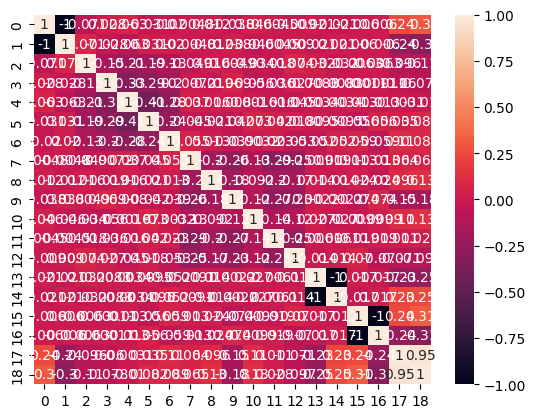

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(pd.DataFrame(X).corr(), annot=True)
plt.show()


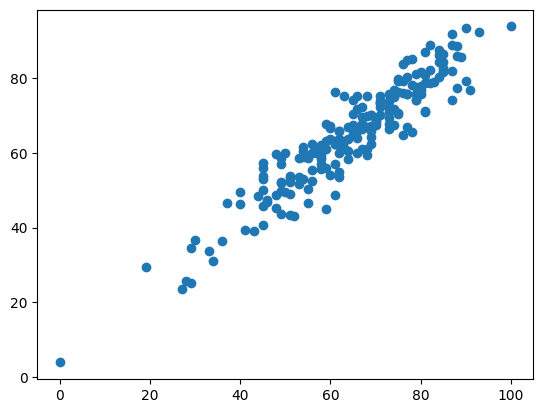

In [90]:
plt.scatter(y_test,y_pred)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

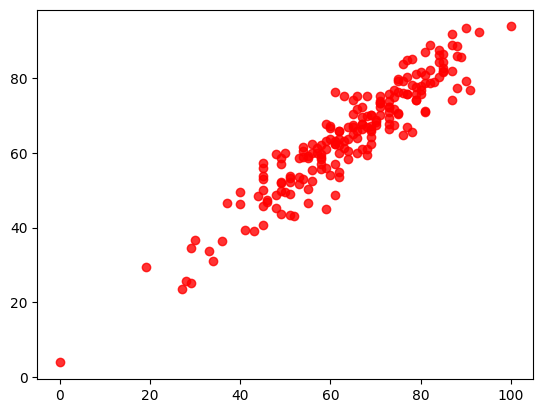

In [91]:
sns.regplot(x=y_test,y=y_pred,color='red',ci='None')